# Simple seq2seq model in keras that translates english <-> german

As a next step I take the model used for the [toy problem of adding/subtracting numbers](SimpleModelForAddingAndSubstraction.ipynb) and train it with english/german data for machine translation.

As trainings set I use the [European Parliament Proceedings Parallel Corpus 1996-2011](http://statmt.org/europarl/) German-English corpus.

In [1]:
# technical detail so that an instance (maybe running in a different window)
# doesn't take all the GPU memory resulting in some strange error messages
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

/home/janek/.local/share/virtualenvs/rosetta-WKmHhL03/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import math
import matplotlib.pyplot as plt
import os
import re
import tarfile

import keras
import keras.layers as L
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

# Fixing random state ensure reproducible results
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
tf.set_random_seed(RANDOM_STATE)

In [3]:
START = '^'
END = '\n'

MAX_INPUT_LENGTH = 25 #50
MAX_TARGET_LENGTH = 35 #65
LATENT_DIM = 512
EMBEDDING_DIM = 64
EPOCHS = 20
BATCH_SIZE = 128
DROPOUT = 0.5
TEST_SIZE = 500

## Download and explore data

In [4]:
def download_file(fname, url):
    print(f"Downloading {fname} from {url} ...")
    response = requests.get(url, stream=True)

    total_size = int(response.headers.get('content-length', 0)); 
    block_size = 1024

    download = tqdm(
        response.iter_content(block_size),
        total=math.ceil(total_size // block_size),
        unit='KB',
        unit_scale=True
    )
    with open(f"{fname}", "wb") as handle:
        for data in download:
            handle.write(data)

PATH = 'data'
FILES = {
    'de-en.tgz': 'http://statmt.org/europarl/v7/de-en.tgz',  # incredible: really only http, not https :-o
}
os.makedirs(PATH, exist_ok=True)

for name, url in FILES.items():
    fname = os.path.join(PATH, name)
    exists = os.path.exists(fname)
    size = os.path.getsize(fname) if exists else -1
    if exists and size > 0:
        print(f'{name} already downloaded ({size / 2**20:3.1f} MB)')
        continue
    download_file(fname, url)
    if (fname.endswith(".tgz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=PATH)
        tar.close()
        print(f'Extracted {fname} ...')


de-en.tgz already downloaded (188.6 MB)


In [5]:
# Following https://github.com/bheinzerling/bpemb/blob/master/preprocess_text.sh
# (ignoring urls as there shouldn't be any in parliament discussions)
def preprocess(line):
    line = re.sub(r'\d+', '0', line)  # replace all numbers by '0'
    line = re.sub(r'\s+', ' ', line)  # strip whitespaces as a ' '
    return line.lower().strip()

def read_corpus_lines(language):
    return [preprocess(line) for line in open(f'{PATH}/europarl-v7.de-en.{language}', 'r').readlines()]
    
pd.set_option('max_colwidth', 60)
df = pd.DataFrame(data={
    'input_texts': read_corpus_lines('en'),
    'target_texts': read_corpus_lines('de'), 
})
df.input_texts = START + df.input_texts + END
df.target_texts = START + df.target_texts + END

In [6]:
len(df)
df['input_length'] = df.input_texts.apply(len)
df['target_length'] = df.target_texts.apply(len)
df.head()

1920209

,input_texts,target_texts,input_length,target_length
0,^resumption of the session\n,^wiederaufnahme der sitzungsperiode\n,27,36
1,^i declare resumed the session of the european parliamen...,"^ich erkläre die am freitag, dem 0. dezember unterbroche...",205,219
2,"^although, as you will have seen, the dreaded 'millenniu...","^wie sie feststellen konnten, ist der gefürchtete ""mille...",193,187
3,^you have requested a debate on this subject in the cour...,^im parlament besteht der wunsch nach einer aussprache i...,107,112
4,"^in the meantime, i should like to observe a minute' s s...",^heute möchte ich sie bitten - das ist auch der wunsch e...,234,219


### Only use short translations right now

So, first I plot sentence length on a logarithmic scale, 
then I only choose short input texts (and a bit longer target texts as german is more verbose than english).

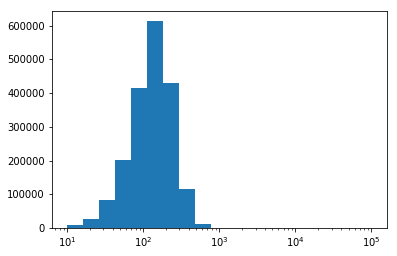

In [7]:
x = df.input_length
logbins = np.logspace(1,5,20)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show();

In [8]:
non_empty = (df.input_length > 3) & (df.target_length > 3)  # there are empty phrases like '\n' --> 'Frau Präsidentin\n'
short_inputs = (df.input_length < MAX_INPUT_LENGTH) & (df.target_length < MAX_TARGET_LENGTH)
sum(short_inputs)
df = df[non_empty & short_inputs]

37048

In [9]:
corpus = pd.concat([df.input_texts, df.target_texts])

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=100, filters=None, char_level=True, oov_token='~')
tokenizer.fit_on_texts(corpus)
df['input_sequences'] = tokenizer.texts_to_sequences(df.input_texts)
df['target_sequences'] = tokenizer.texts_to_sequences(df.target_texts)

In [11]:
list(reversed(sorted(tokenizer.word_counts.items(), key=lambda d: d[1])))
sum(1 for w, count in tokenizer.word_counts.items() if count > 1000)

[(' ', 110091),
 ('e', 108525),
 ('s', 77830),
 ('i', 65877),
 ('a', 63543),
 ('t', 62244),
 ('\n', 55276),
 ('^', 55276),
 ('n', 49940),
 ('h', 42837),
 ('r', 39035),
 ('l', 36762),
 ('o', 36097),
 ('d', 34400),
 ('.', 29935),
 ('c', 28517),
 ('u', 27674),
 ('p', 18168),
 ('b', 17963),
 ('g', 17747),
 ('m', 14753),
 ('w', 14353),
 ('f', 11380),
 ('(', 8198),
 ('k', 8167),
 (')', 8032),
 ('y', 6654),
 ('v', 6087),
 ('?', 5693),
 ('0', 3852),
 ('z', 3610),
 ('!', 3374),
 ('-', 2320),
 (',', 2308),
 (':', 2073),
 ('ü', 1623),
 ('ä', 1436),
 ('j', 940),
 ('ö', 901),
 ('/', 804),
 ('ß', 690),
 ('x', 575),
 ('q', 418),
 ("'", 221),
 ('"', 156),
 ('%', 57),
 ('–', 47),
 ('é', 37),
 ('á', 33),
 ('í', 27),
 ('°', 24),
 ('’', 19),
 (';', 16),
 ('*', 15),
 ('è', 15),
 ('“', 10),
 (']', 10),
 ('…', 9),
 ('ã', 9),
 ('[', 9),
 ('‘', 8),
 ('ï', 8),
 ('å', 7),
 ('ó', 6),
 ('α', 5),
 ('ă', 5),
 ('š', 5),
 ('„', 4),
 ('ñ', 4),
 ('π', 4),
 ('ň', 4),
 ('о', 4),
 ('д', 4),
 ('•', 4),
 ('ł', 4),
 ('ο', 3),

37

In [12]:
max_len_input = df.input_length.max()
max_len_target = df.target_length.max()
nr_tokens = len(tokenizer.word_index) + 1  # add 0 padding not in word_index contained

# one hot encoded y_t_output wouldn't fit into memory any longer
# so need to train/validate on batches generated on the fly
def create_batch_generator(samples_ids):
    
    def batch_generator():
        nr_batches = np.ceil(len(samples_ids) / BATCH_SIZE)
        while True:
            shuffled_ids = np.random.permutation(samples_ids)
            batch_splits = np.array_split(shuffled_ids, nr_batches)
            for batch_ids in batch_splits:
                batch_X = pad_sequences(df.iloc[batch_ids].input_sequences, padding='post', maxlen=max_len_input)
                batch_y = pad_sequences(df.iloc[batch_ids].target_sequences, padding='post', maxlen=max_len_target)
                batch_y_t_output = keras.utils.to_categorical(batch_y[:,1:], num_classes=len(tokenizer.word_index)+1)
                batch_x_t_input = batch_y[:,:-1]
                yield ([batch_X, batch_x_t_input], batch_y_t_output)
    
    return batch_generator()

In [13]:
train_ids, val_ids = train_test_split(np.arange(df.shape[0]), test_size=0.1)

In [14]:
nr_tokens
len(tokenizer.word_index)
len(train_ids), len(val_ids)

111

110

(24874, 2764)

In [15]:
encoder_gru = L.Bidirectional(
    L.GRU(LATENT_DIM // 2, dropout=DROPOUT, return_state=True, name='encoder_gru'),
    name='encoder_bidirectional'
)
decoder_gru = L.GRU(LATENT_DIM, dropout=DROPOUT, return_sequences=True, return_state=True, name='decoder_gru')
decoder_dense = L.Dense(nr_tokens, activation='softmax', name='decoder_outputs')

shared_embedding = L.Embedding(nr_tokens, EMBEDDING_DIM, mask_zero=True, name='shared_embedding')

encoder_inputs = L.Input(shape=(max_len_input, ), dtype='int32', name='encoder_inputs')
encoder_embeddings = shared_embedding(encoder_inputs)
_, encoder_state_1, encoder_state_2 = encoder_gru(encoder_embeddings)
encoder_states = L.concatenate([encoder_state_1, encoder_state_2])

decoder_inputs = L.Input(shape=(max_len_target-1, ), dtype='int32', name='decoder_inputs')
decoder_mask = L.Masking(mask_value=0)(decoder_inputs)
decoder_embeddings_inputs = shared_embedding(decoder_mask)
decoder_embeddings_outputs, _ = decoder_gru(decoder_embeddings_inputs, initial_state=encoder_states) 
decoder_outputs = decoder_dense(decoder_embeddings_outputs)


model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

inference_encoder_model = Model(encoder_inputs, encoder_states)
    
inference_decoder_state_inputs = L.Input(shape=(LATENT_DIM, ), dtype='float32', name='inference_decoder_state_inputs')
inference_decoder_embeddings_outputs, inference_decoder_states = decoder_gru(
    decoder_embeddings_inputs, initial_state=inference_decoder_state_inputs
)
inference_decoder_outputs = decoder_dense(inference_decoder_embeddings_outputs)

inference_decoder_model = Model(
    [decoder_inputs, inference_decoder_state_inputs], 
    [inference_decoder_outputs, inference_decoder_states]
)

In [16]:
model.summary()
inference_decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 33)           0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 33)           0           decoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     (None, 24)           0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    multiple             7104        encoder_inputs[0][0]             
                                                                 masking_1[0][0]                  
__________

In [17]:
model.compile(optimizer=keras.optimizers.Adam(clipnorm=1.), loss='categorical_crossentropy')

In [18]:
train_generator = create_batch_generator(train_ids)
val_generator = create_batch_generator(val_ids)
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(len(train_ids) / BATCH_SIZE),
    epochs=20,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_ids) / BATCH_SIZE),
)
#model.fit([X, x_t_input], y_t_output, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
195/195 [==============================] - 16s 80ms/step - loss: 2.2041 - val_loss: 1.3468
Epoch 2/20
195/195 [==============================] - 13s 69ms/step - loss: 1.1757 - val_loss: 0.9938
Epoch 3/20
195/195 [==============================] - 13s 65ms/step - loss: 0.9389 - val_loss: 0.8588
Epoch 4/20
195/195 [==============================] - 13s 65ms/step - loss: 0.8076 - val_loss: 0.7945
Epoch 5/20
195/195 [==============================] - 14s 70ms/step - loss: 0.7247 - val_loss: 0.6938
Epoch 6/20
195/195 [==============================] - 13s 68ms/step - loss: 0.6636 - val_loss: 0.6648
Epoch 7/20
195/195 [==============================] - 13s 67ms/step - loss: 0.6160 - val_loss: 0.6361
Epoch 8/20
195/195 [==============================] - 13s 66ms/step - loss: 0.5785 - val_loss: 0.6210
Epoch 9/20
195/195 [==============================] - 14s 72ms/step - loss: 0.5459 - val_loss: 0.5890
Epoch 10/20
195/195 [==============================] - 13s 66ms/step - loss: 0.517

In [19]:
def decode_sequence(input_seq):
    states_value = inference_encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, max_len_target-1))
    target_seq[0, 0] = tokenizer.word_index[START]
    
    tokens = {idx: token for (token, idx) in tokenizer.word_index.items()}
    
    decoded_sequence = ''
    for i in range(max_len_target):
        output_tokens, output_states = inference_decoder_model.predict(
            [target_seq, states_value]
        )
        
        # greedy search
        sampled_token_idx = np.argmax(output_tokens[0, 0, :])
        sampled_token = tokens.get(sampled_token_idx, '.')
        if sampled_token == END:
            break
        decoded_sequence += sampled_token
            
        target_seq[0, 0] = sampled_token_idx
        states_value = output_states
    
    return decoded_sequence 

In [20]:
def predict(sentence):
    return decode_sequence(keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences([preprocess(sentence)]),
        padding='post',
        maxlen=max_len_input,
    ))

In [21]:
# Performance on some examples:
EXAMPLES = [
    'Hello.',
    'You are welcome.',
    'How do you do?',
    'I hate mondays.',
    'I am a programmer.',
    'Data is the new oil.',
    'It could be worse.',
    "I am on top of it.",
    "N° Uno",
    "Awesome!",
    "Put your feet up!",
    "From the start till the end!",
    "From dusk till dawn.",
]
for en in [sentence + '\n' for sentence in EXAMPLES]:
    print(f"{preprocess(en)!r} --> {predict(en)!r}")

'hello.' --> 'hallo von allein.'
'you are welcome.' --> 'sie haben verständlich.'
'how do you do?' --> 'wie können wir das tun?'
'i hate mondays.' --> 'ich habe dafür gestimmt.'
'i am a programmer.' --> 'ich bin falsch.'
'data is the new oil.' --> 'heute ist der stand.'
'it could be worse.' --> 'das war das zeit begrüßen.'
'i am on top of it.' --> 'ich bin nicht darüber beispiel.'
'n° uno' --> 'neine'
'awesome!' --> 'absolut gemeint!'
'put your feet up!' --> 'wie sind das ein anfank!'
'from the start till the end!' --> 'wir müssen das aber abgehen!'
'from dusk till dawn.' --> 'aus dazu gehört geran werden.'


In [22]:
# Performance on training set:
for en, de in df[['input_texts', 'target_texts']][1:20].values.tolist():
    print(f"Original {preprocess(en)!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original '^relating to wednesday:', got 'zum mittwoch:', exp: 'zum mittwoch:\n'
Original '^that was the decision.', got 'das war die frage.', exp: 'das war der beschluß.\n'
Original '^thank you very much.', got 'vielen dank.', exp: 'vielen dank.\n'
Original '^that did not happen.', got 'das ist nicht geschehen.', exp: 'dazu kam es nicht.\n'
Original '^the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^what is the result?', got 'was ist das problem?', exp: 'was sind die folgen?\n'
Original '^the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^thank you very much.', got 'vielen dank.', exp: 'vielen dank!\n'
Original '^with what aim?', go

In [23]:
# Performance on validation set
val_df = df.iloc[val_ids]
for en, de in val_df[['input_texts', 'target_texts']][1:20].values.tolist():
    print(f"Original {preprocess(en)!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original '^it is very important.', got 'das ist wichtig.', exp: 'sie ist sehr wichtig.\n'
Original '^the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^the debate is closed', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^thank you, mr camre.', got 'vielen dank, herr marín.', exp: 'vielen dank, lieber kollege.\n'
Original "^signed: joão correa' .", got 'das gegenteil ist der fall.', exp: 'gezeichnet: joão correa. "\n'
Original '^the debate is closed.', got 'die aussprache ist geschlossen.', exp: 'die aussprache ist geschlossen.\n'
Original '^we need priorities.', got 'wir brauchen reformen.', exp: 'wir brauchen prioritäten.\n'
Original '^and so we shall be.', got 'und das wollen wir alle tun.', exp: 'das werden wir auch.\n'
Original '^- report: thomsen', got '- bericht vergen', exp: '- bericht: thomsen\n'
Original '^definitely not.', got 'das gegenteil ist der fall.', exp: 'ganz 

In [24]:
import spacy
try:
    from spacy.lang.de import German
except ModuleNotFoundError:
    spacy.cli.download('de')
    from spacy.lang.de import German
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

parser = German()
chencherry = SmoothingFunction()  # to handle short sequences, see also http://www.nltk.org/_modules/nltk/translate/bleu_score.html#SmoothingFunction.method3

def remove_spaces_and_puncts(tokens):
     return [token.orth_ for token in tokens if not (token.is_space or token.is_punct)]  

bleu_scores = np.zeros(TEST_SIZE)
nist_scores = np.zeros(TEST_SIZE)

for i in tqdm(range(TEST_SIZE)):
    pred_tokens = remove_spaces_and_puncts(parser(predict(df.iloc[i].input_texts)))
    ref_tokens = remove_spaces_and_puncts(parser(df.iloc[i].target_texts[1:]))
    bleu_scores[i] = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=chencherry.method3)
    
print("Average bleu score:", bleu_scores.mean())


Average bleu score: 0.3790106443397856


In [25]:
## Conclusion

# It doesn't work perfect, but fine enough to show that seq2seq works in some way. I wouldn't be surprised if the mean average error is better than average human bias for calculating without any tools.
# For improvements and further discussions I'll move to a real problem (translating) and main steps will be:
# * Bytepairencoding/Word embeddings
# * Beam Search
# * Attention models